continuous numbers: [   0    1    1 ... 9998 9998 9999]
(24346, 5)
[0.000e+00 1.000e+00 2.000e+00 ... 9.997e+03 9.998e+03 9.999e+03]
well reco... 0.7983798379837984


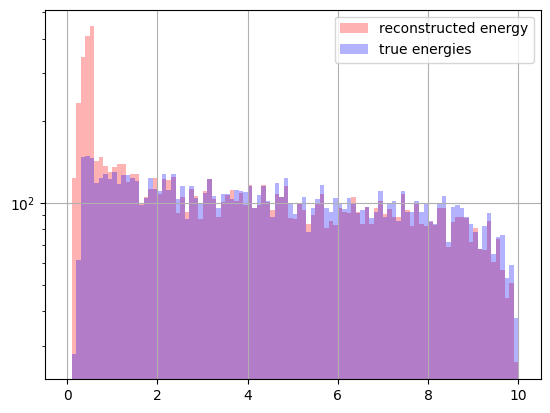

In [1]:
import numpy as np
from numpy import genfromtxt
from itertools import combinations
import torch
import math 
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fclusterdata
import networkx as nx
%run r3b_clustering_def.ipynb

In [2]:
def df_sph_to_cart(arr):
    ##input data has columns eventnr, energy, theta, phi, hit-time
    r = arr[:,4]*2.5
    energy = arr[:,1]
    theta = arr[:,2]
    phi = arr[:,3]
    rsin_theta = r*np.sin(theta)
    x = rsin_theta*np.cos(phi)
    y = rsin_theta*np.sin(phi)
    z = r*np.cos(theta)
    cart_arr = np.concatenate((x.reshape(-1,1),y.reshape(-1,1),z.reshape(-1,1),energy.reshape(-1,1)), axis=1)
    return cart_arr



In [3]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [4]:
def run_agglo_clustering(data,threshold):
    array_unique_events = np.unique(data[:,0])
    all_pred = []
    print(int(np.max(data,axis=0)[0])-(int(np.max(data,axis=0)[0])%3))
    for i in range(0,int(np.max(data,axis=0)[0])-(int(np.max(data,axis=0)[0])%3) ,3):
        print("unique stuff:\t",array_unique_events[i+2])
        evt = data[data[:,0] == array_unique_events[i]]
        evt = np.vstack((evt,data[data[:,0] == array_unique_events[i+1]]))
        evt = np.vstack((evt,data[data[:,0] == array_unique_events[i+2]]))
        nr_hits = evt.shape[0]
        hitnr = np.array([x for x in range(evt.shape[0])])
        hitnr = np.transpose(hitnr)
        hitnr = hitnr.reshape(-1, 1)
        ### transform event from  eventnr, energy, theta, phi, hit-time to 'x','y','z','energy'
        evt_cart = df_sph_to_cart(evt)
        ### insert agglomerative algorithm
        output = fclusterdata(evt_cart, t=threshold, criterion='distance',method="ward")
        output = np.reshape(output,(-1,1))
        output = output.astype(int)
        evt = np.append(evt,output,axis=1)
        nr_reco_cluster = np.max(output)
        cluster_list = []
        for i in range(1,nr_reco_cluster+1):
            subl = []
            for j in range(evt.shape[0]):
                if (evt[j,5] == i):
                    subl.append(j)
            cluster_list.append(subl)        
        #compress list of clusters, they need at least two entries to be a cluster, otherwise the single hit is treated as cluster
        compr_cluster_list = []
        for i in range(len(cluster_list)):
            if len(cluster_list[i]) > 1:
                compr_cluster_list.append(cluster_list[i])
            else:
                continue
        final_pair_list = []
        for i in range(len(compr_cluster_list)):
            pair_indices = list(combinations(compr_cluster_list[i],2))
            final_pair_list.append(pair_indices)
        reco_indices = flatten(final_pair_list)
        
        # compare all combinations with all predicted combinations
        all_combinations = list(combinations(range(nr_hits), 2))
        ## predictions
        pred_list = []
        for i in range(len(all_combinations)):
            pred_value = 0
            for j in range(len(reco_indices)):
                if (all_combinations[i] == reco_indices[j]):
                    pred_value = 1
            pred_list.append(pred_value)
            all_pred.append(pred_value)
    return all_pred


In [5]:
# #data = genfromtxt('raw_data_test.txt', delimiter=',')
# #data = genfromtxt('data_raw_uniform_test.csv', delimiter=',')
# #data = genfromtxt('data_stream_2121.txt', delimiter=',')
# data = genfromtxt('demo_file.txt', delimiter=',')
# data[:,4] = data[:,4]+4500  #this step is needed, I only want positive time values, so that I can use the time as a radius
# #my_data[:,4] = 1  #this step is needed, I only want positive time values, so that I can use the time as a radius



# # ### structure of mydata : eventnr, energy, theta, phi, hit-time
# data = data*[1.,1.,3.14159/180,3.14159/180,1.]
# unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
# data[:,0] = continuous_numbers
# print(data)
# out_cluster_agglo = run_agglo_clustering(data,3540)
# #foo = plot_true_reco(data)
# foo_comb = get_true_combinatorics(data)
# print("data size:", len(out_cluster_agglo))
# print("true_size:",len(foo_comb))
# print("type of out_cluster_agglo:",type(out_cluster_agglo))
# print("and this is out_cluster_agglo", out_cluster_agglo)
# foo_ene = get_true_reco_ene(data,out_cluster_agglo,foo_comb)


---

### test from here if I can write clustered data to file...

In [6]:
#write_reco_to_file_cms(data,out_cluster_agglo)